In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

In [2]:
def shuffle_array(array):
    X_array = array.copy()
    rows, columns = array.shape
    for col in range(columns):
        ixes = np.arange(0,rows)
        np.random.shuffle(ixes)
        X_array[:,col] = X_array[:,col][ixes]
    return X_array

def shuffle_array_range(array, ranges):
    X_array = []
    for x1, x2 in ranges:
        X = wvf[:,x1:x2]
        np.random.shuffle(X)
        X_array.append(X)
    return np.hstack(X_array)

def get_num_components(waveforms, n_comps):
    # robust scaling
    waveforms_scaled = RobustScaler().fit_transform(waveforms)

    # main PCA fitting
    pca_full = PCA(n_components=n_comps)
    pcs_full = pca_full.fit_transform(waveforms_scaled)
    var_full = pca_full.explained_variance_ratio_ 

    # robustness of pca components
    no_of_iter = 100
    pca_vars = []
    for i in range(no_of_iter):
        shuffled_wvf = shuffle_array(waveforms_scaled)

        pca_shuff = PCA(n_components=n_comps)
        pca_shuff.fit(shuffled_wvf)
        pca_vars.append(pca_shuff.explained_variance_ratio_)        
    del shuffled_wvf
    pca_vars=np.array(pca_vars)

    # getting the magic number
    results = np.sum(var_full>pca_vars, axis=0) / no_of_iter
    threshold=1-(.05/n_comps)
    PCS_to_analyse = np.where(results > threshold)[0]
    return PCS_to_analyse

In [3]:
waveform_array_file = r'C:\Users\qmoreau\Documents\Work\Beta_bursts\Burst_files\all_waveforms.npy'
waveform_array = np.load(waveform_array_file)

In [4]:
behav_df = pd.read_csv(r'C:\Users\qmoreau\Documents\Work\Beta_bursts\Behavioral\behav_df_cleaned_new.csv')
burst_df = pd.read_csv(r'C:\Users\qmoreau\Documents\Work\Beta_bursts\Bursts\burst_features.csv')

In [5]:
lookup_df = behav_df[["coh_cat", "perturb_cat", "trial", "block", "subject", "group"]]
df_burst_behav = burst_df.merge(
    lookup_df, 
    on=["trial", "block", "subject"], 
    how='left'
)

In [6]:
chunk_size = 1000  # Adjust based on your system's memory
df_burst_behav_adapt = []

# Preprocess lookup_df to reduce memory usage
lookup_df = behav_df[["coh_cat", "perturb_cat", "trial", "block", "subject", "group"]].copy()

# Optimize memory usage of lookup_df
for col in lookup_df.select_dtypes(include=['object']).columns:
    lookup_df[col] = lookup_df[col].astype('category')

# Use chunksize and more memory-efficient merge
for chunk in pd.read_csv('C:/Users/qmoreau/Documents/Work/Beta_bursts/Bursts/burst_features.csv', 
                         chunksize=chunk_size, 
                         dtype={
                             'trial': 'int32', 
                             'subject': 'category',
                             # Add other columns with appropriate dtypes
                         }):
    # Ensure consistent dtypes before merging
    chunk['trial'] = chunk['trial'].astype('int32')
    chunk['subject'] = chunk['subject'].astype('category')
    
    # Merge with specific columns
    chunk_merged = chunk.merge(
        lookup_df, 
        on=["trial", "subject"], 
        how='left'
    )
    
    df_burst_behav_adapt.append(chunk_merged)

# Concatenate efficiently
df_burst_behav_adapt = pd.concat(df_burst_behav_adapt, ignore_index=True)

In [7]:
waveforms_motor = waveform_array[df_burst_behav['epoch']=="mot"]

In [8]:
# shuffling_results=get_num_components(waveforms_motor, 20)
# print(f'Non-noise PCs: {shuffling_results}')

In [9]:
df_mot = df_burst_behav[df_burst_behav['epoch'] == 'mot']
# df_mot_adaptation for blocks between above 0 and below 7
df_mot_adaptation = df_mot[(df_mot['block'] > 0) & (df_mot['block'] < 7)]

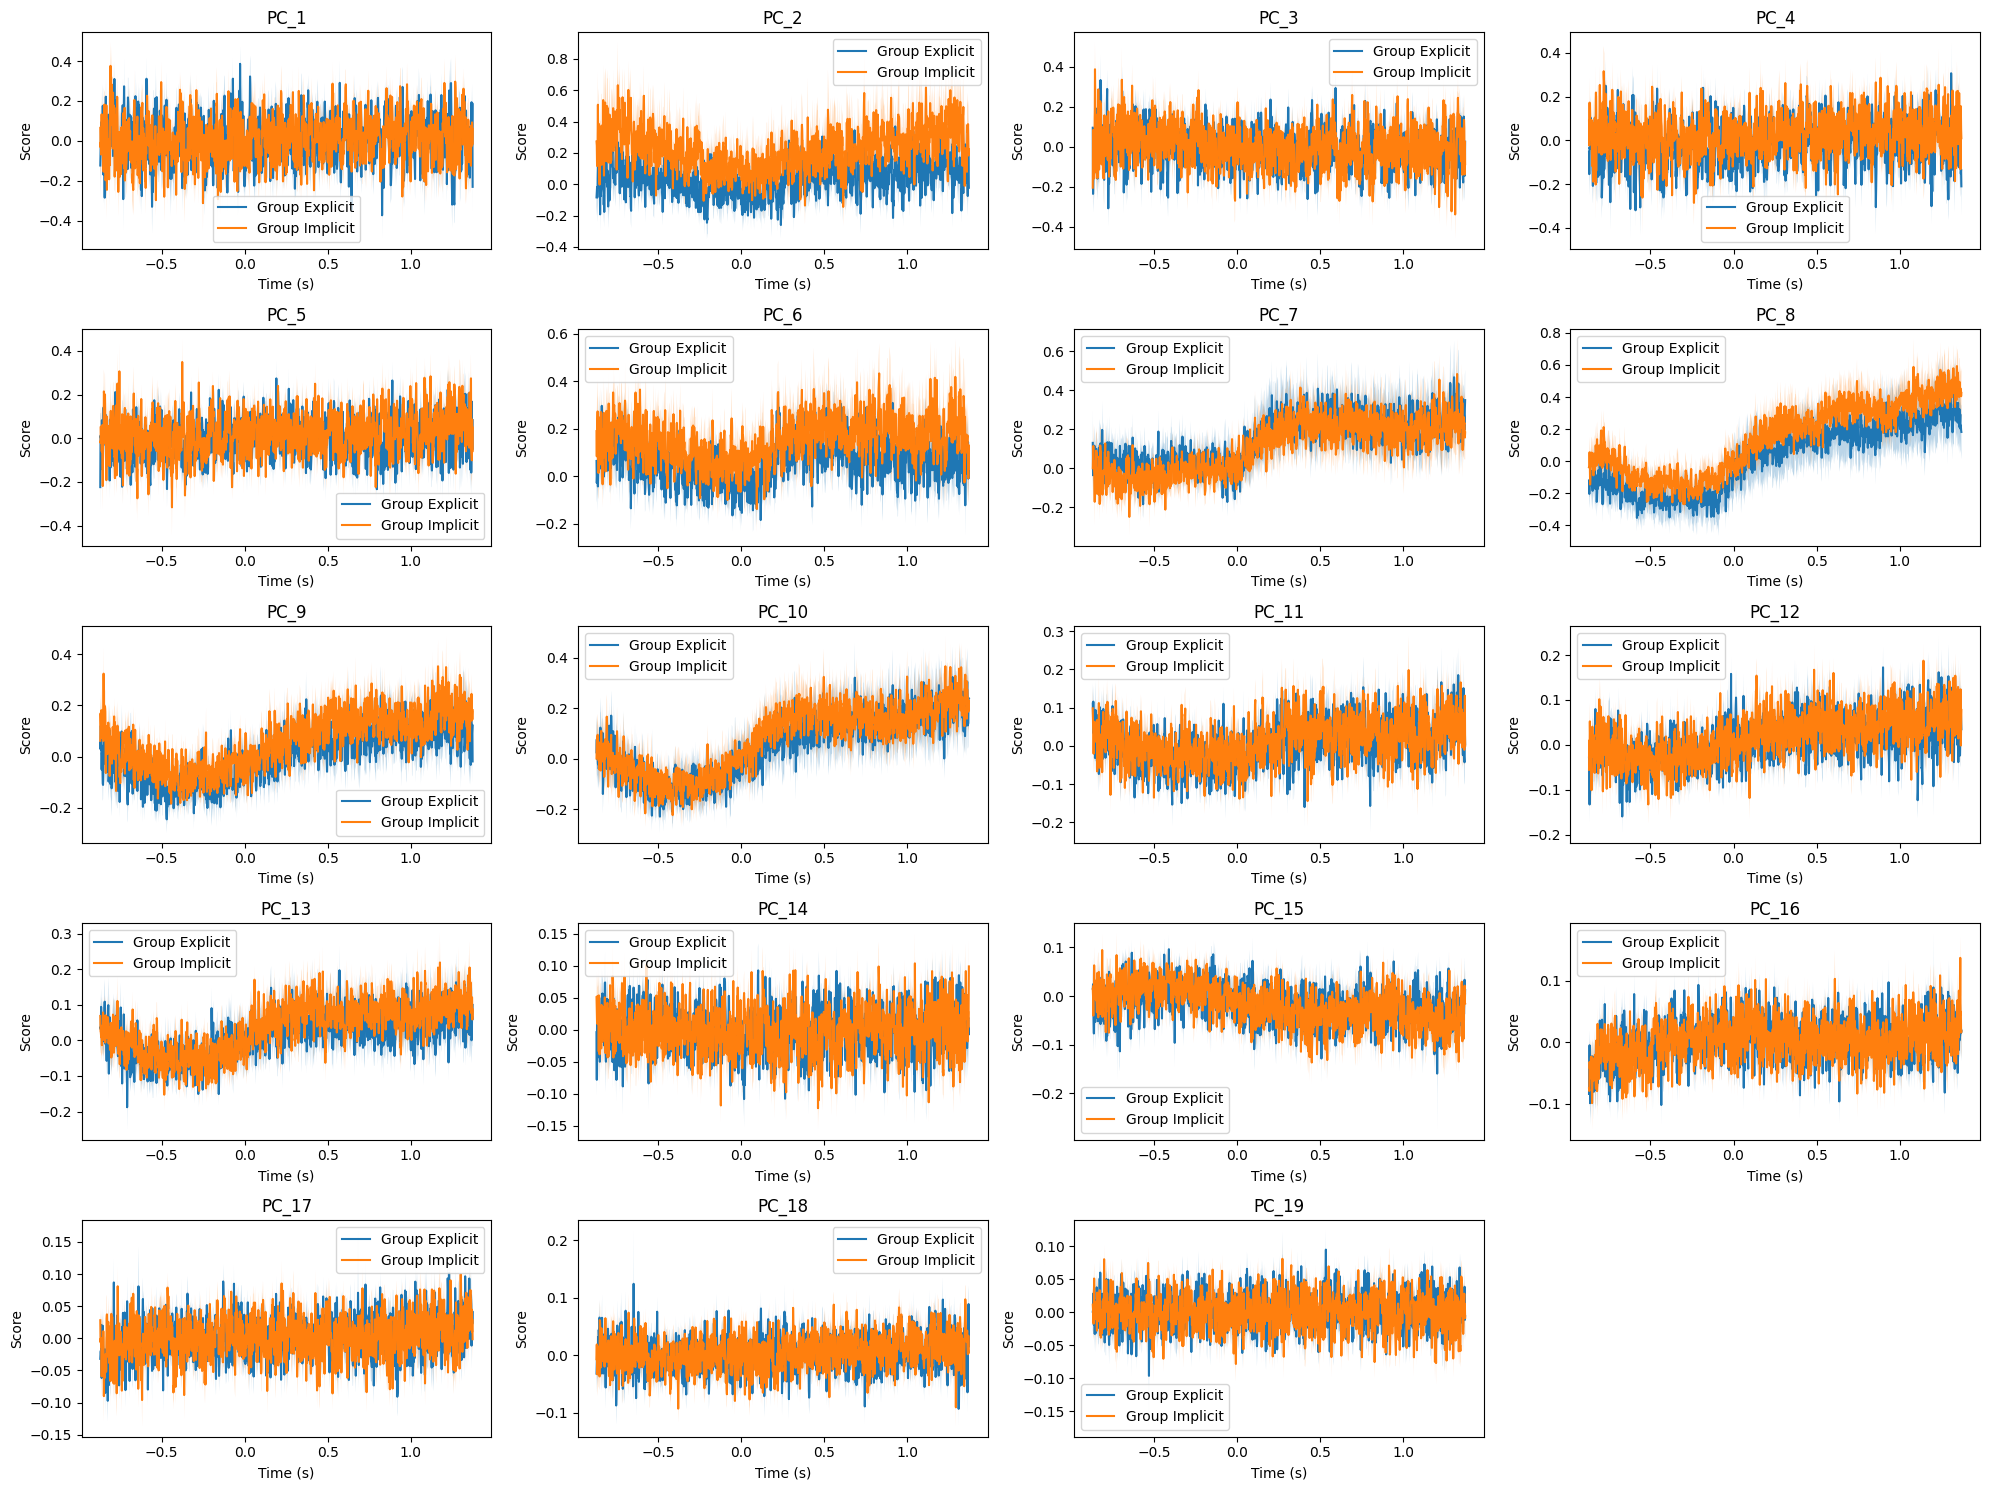

In [10]:
# Create subplots
pcs = [f"PC_{i}" for i in range(1, 20)]
groups = df_mot['group'].unique()

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 15))
axes = axes.flatten()

# Plot each PC in a subplot
for i, pc in enumerate(pcs):
    ax = axes[i]
    for group in groups:
        group_data = df_mot[df_mot['group'] == group]

        # Average within each subject first
        subject_means = group_data.groupby(['subject', 'peak_time'])[pc].mean().unstack()

        # Grand average across subjects
        grand_mean = subject_means.mean(axis=0)
        se = subject_means.sem(axis=0)

        # Convert to numeric, handling NaNs
        grand_mean = pd.to_numeric(grand_mean, errors='coerce')
        se = pd.to_numeric(se, errors='coerce')

        # Plot
        ax.plot(grand_mean.index, grand_mean.values, label=f"Group {group}")
        ax.fill_between(
            grand_mean.index,
            grand_mean - se,
            grand_mean + se,
            alpha=0.3
        )
    
    ax.set_title(pc)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Score")
    ax.legend()

# Remove extra subplots if any
for j in range(len(pcs), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()




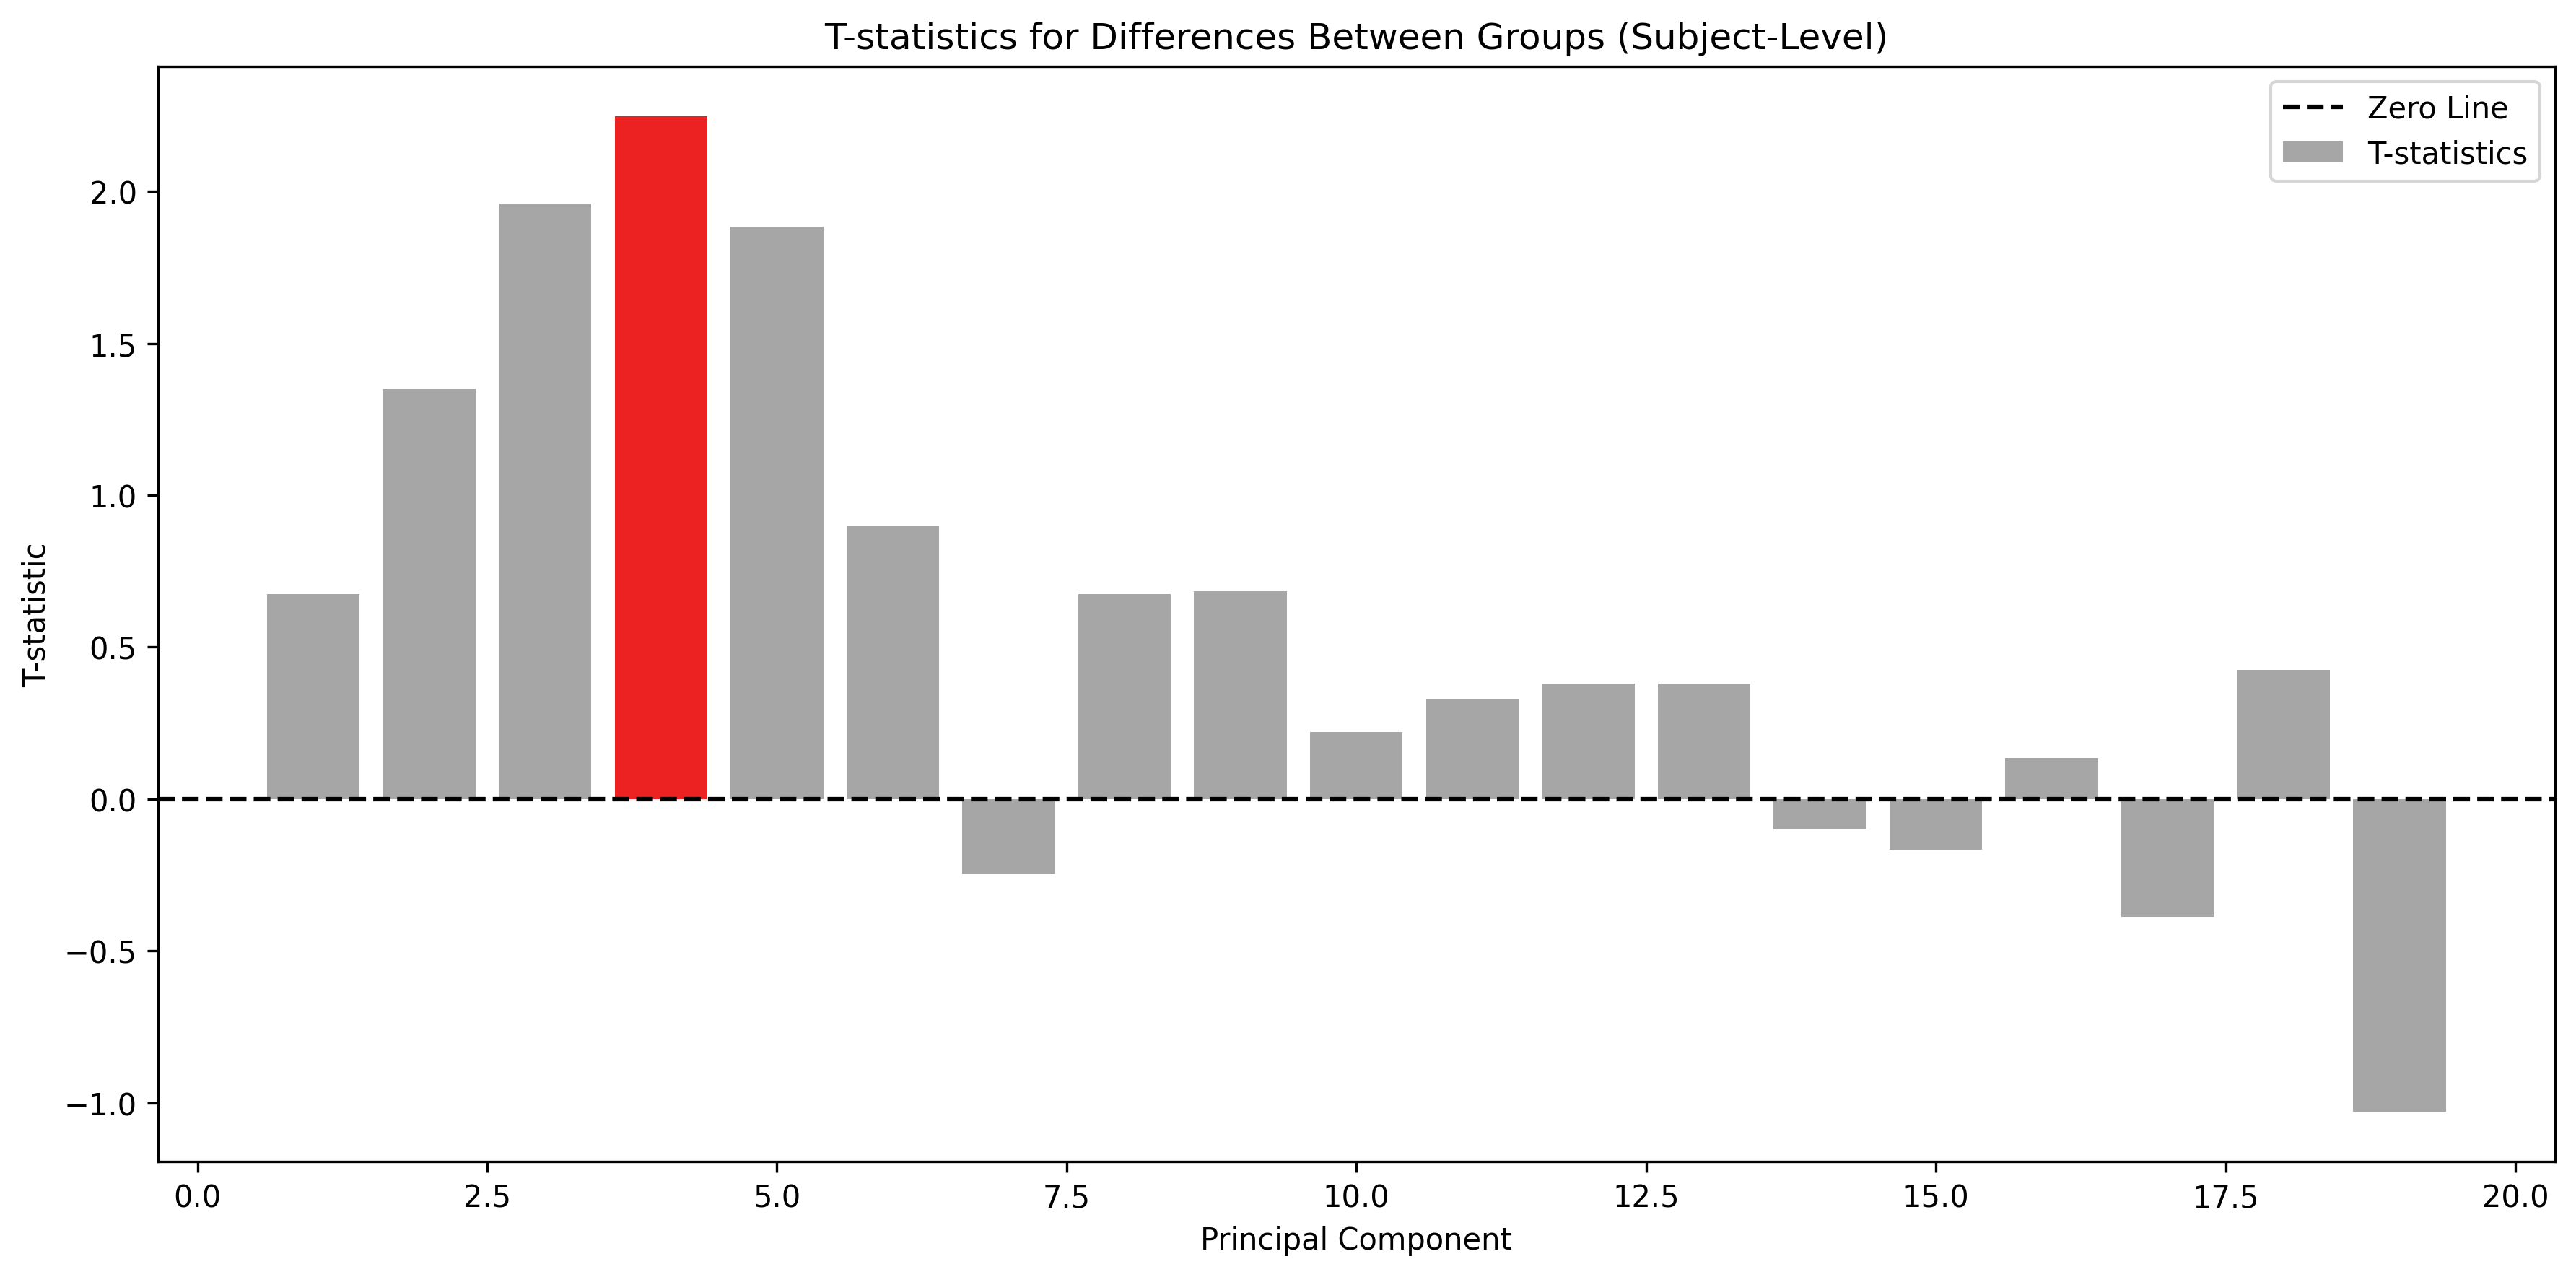

Significant PCs: ['PC_4']


In [14]:
from scipy.stats import ttest_ind

# Parameters
pcs = [f"PC_{i}" for i in range(1, 20)]
groups = df_mot['group'].unique()

# Step 1: Aggregate PC scores at the subject level
subject_means = df_mot.groupby(['subject', 'group'])[pcs].mean().reset_index()

# Step 2: Compute observed t-statistics
t_stats = {}
p_values = {}
for pc in pcs:
    imp_scores = subject_means[subject_means['group'] == 'Implicit'][pc]
    exp_scores = subject_means[subject_means['group'] == 'Explicit'][pc]
    t_stat, p_val = ttest_ind(imp_scores, exp_scores, equal_var=False)
    t_stats[pc] = t_stat
    p_values[pc] = p_val

# Step 3: Identify significant PCs (p < 0.05)
significant_pcs = [pc for pc, p_val in p_values.items() if p_val < 0.05]

# Step 4: Plot t-statistics for all PCs
f, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=300, facecolor="white")

# Bar plot for t-statistics
t_values = np.array([t_stats[pc] for pc in pcs])
pc_indices = np.arange(len(pcs)) + 1
ax.bar(pc_indices, t_values, color="gray", alpha=0.7, label="T-statistics")

# Highlight significant PCs
for i, pc in enumerate(pcs):
    if pc in significant_pcs:
        ax.bar(pc_indices[i], t_values[i], color="red", alpha=0.8, label="Significant" if i == 0 else None)

# Add a zero line for reference
ax.axhline(0, color="black", linestyle="--", label="Zero Line")
ax.set_xlabel("Principal Component")
ax.set_ylabel("T-statistic")
ax.set_title("T-statistics for Differences Between Groups (Subject-Level)")
ax.legend()

plt.tight_layout()
plt.show()

# Step 5: Output significant PCs
print("Significant PCs:", significant_pcs)


C:\Users\qmoreau\AppData\Local\Temp\ipykernel_22460\4069047457.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mot['time_bin'] = pd.cut(df_mot['peak_time'], bins=bin_edges, include_lowest=True)


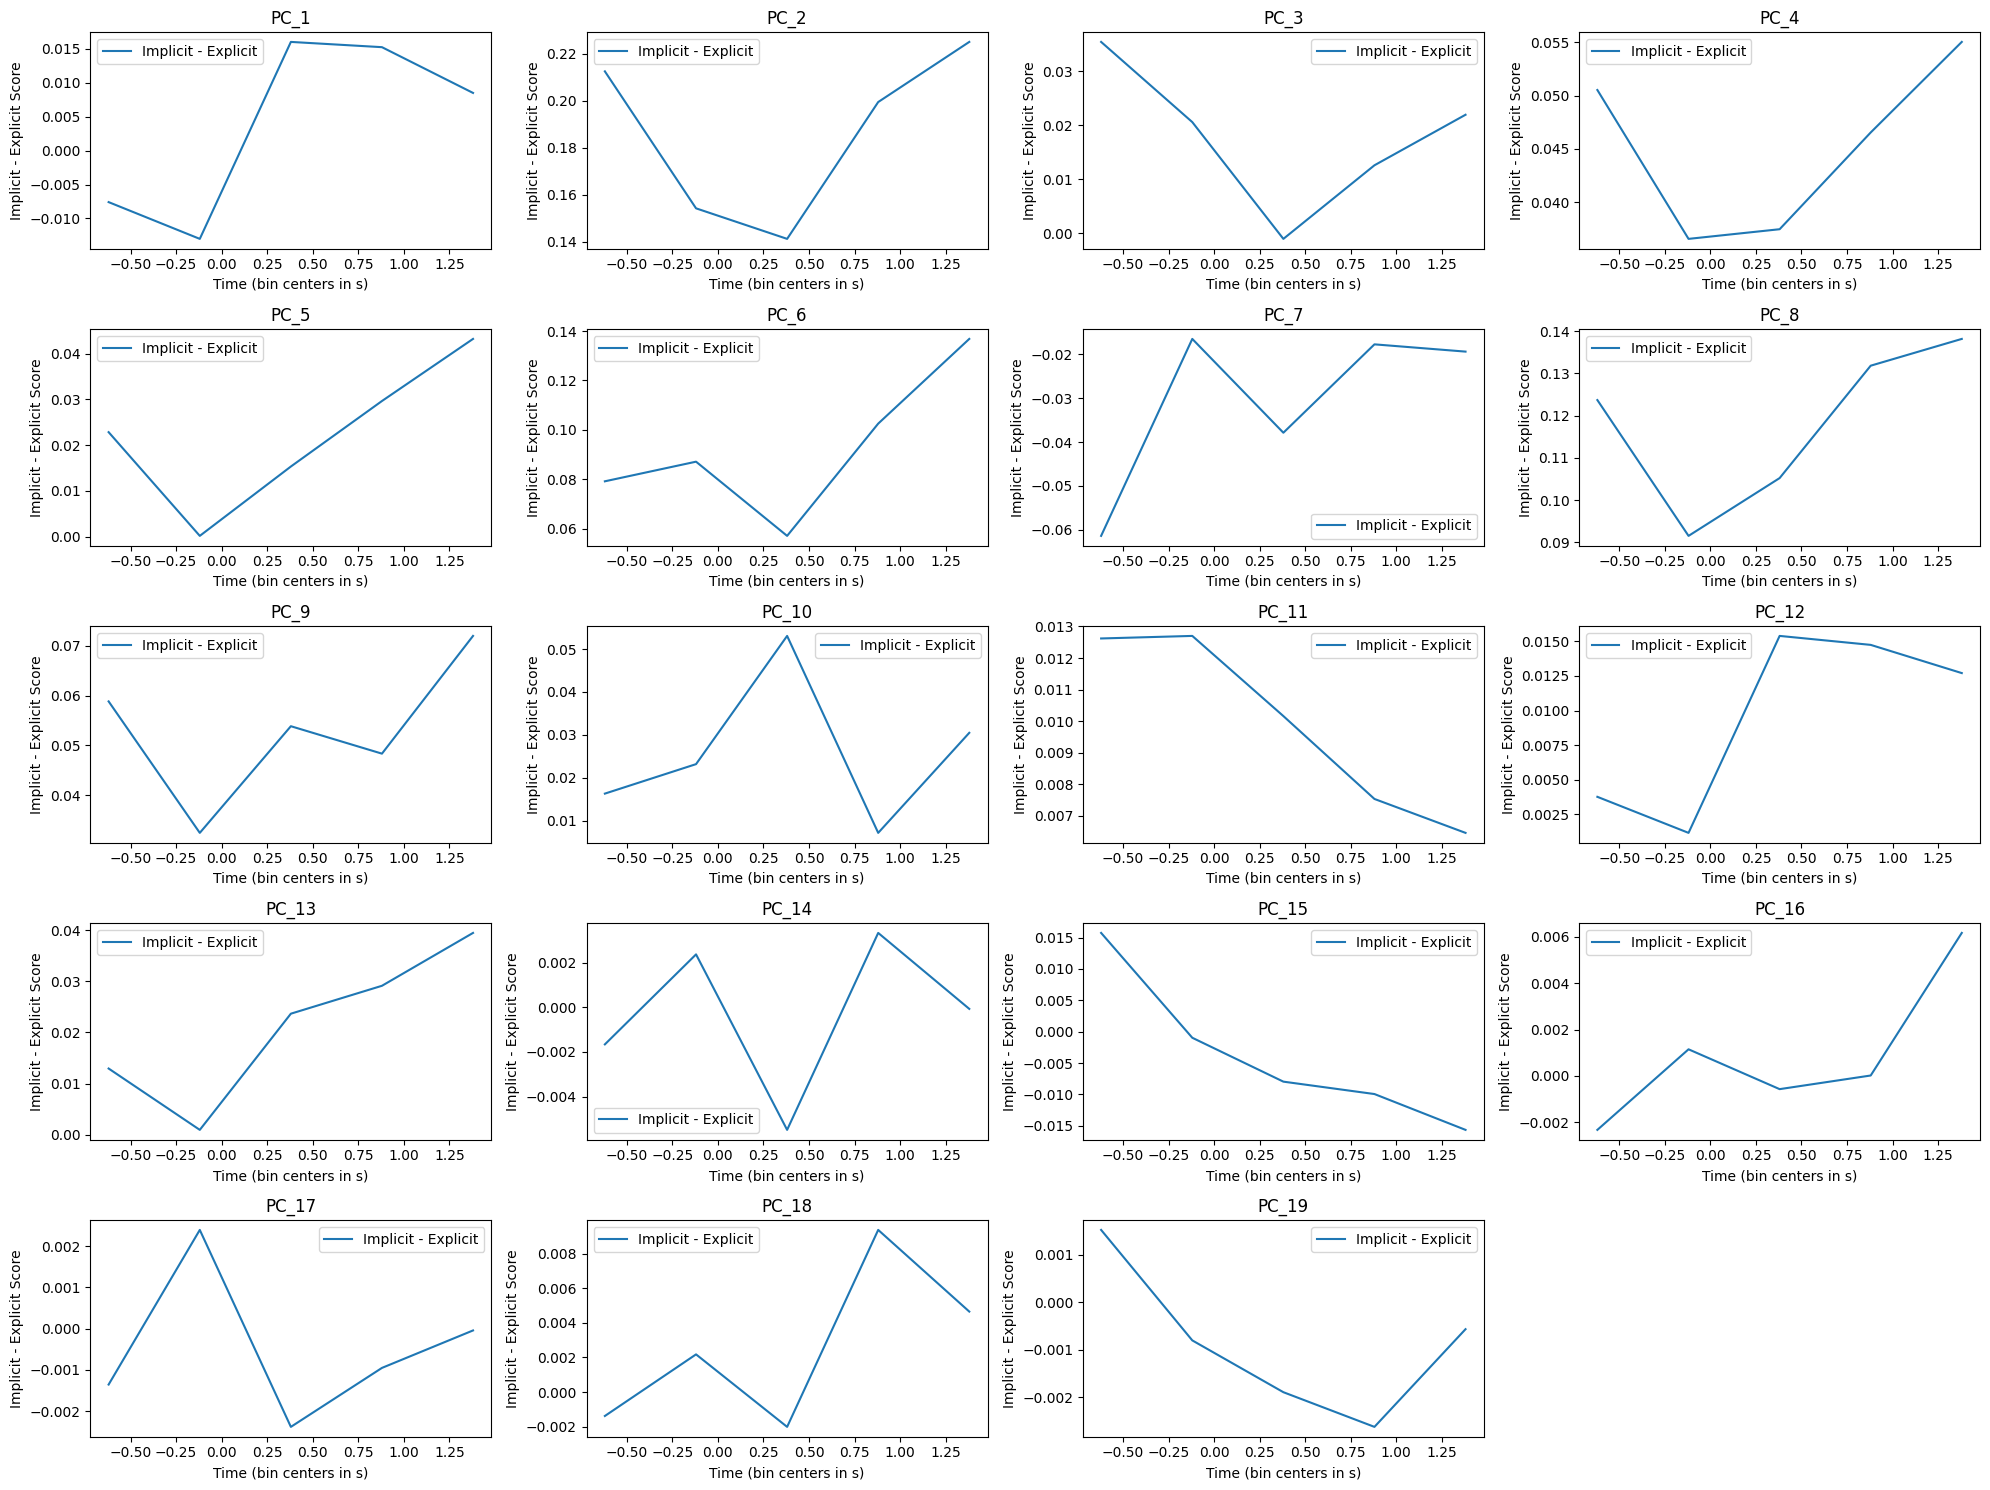

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Specify your PCs
pcs = [f"PC_{i}" for i in range(1, 20)]

# Define your bin edges (e.g., 0.5s wide bins) -- adjust as needed
time_bin_size = 0.5  # 0.5 seconds per bin (example)
time_min = df_mot['peak_time'].min()
time_max = df_mot['peak_time'].max()

# Create a sequence of bin edges from the min to max time
bin_edges = np.arange(time_min, time_max + time_bin_size, time_bin_size)

# Create a new column that assigns each row to a bin
df_mot['time_bin'] = pd.cut(df_mot['peak_time'], bins=bin_edges, include_lowest=True)

# --- Create subplots for each PC ---
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 15))
axes = axes.flatten()

for i, pc in enumerate(pcs):
    ax = axes[i]

    # Split data into Implicit vs. Explicit
    df_implicit = df_mot[df_mot['group'] == 'Implicit']
    df_explicit = df_mot[df_mot['group'] == 'Explicit']
    
    # 1) Group by subject + time_bin, then take the mean of the PC
    subject_means_implicit = df_implicit.groupby(['subject', 'time_bin'])[pc].mean().unstack()
    subject_means_explicit = df_explicit.groupby(['subject', 'time_bin'])[pc].mean().unstack()
    
    # 2) Compute the grand mean (across subjects) for each bin
    grand_mean_implicit = subject_means_implicit.mean(axis=0)
    grand_mean_explicit = subject_means_explicit.mean(axis=0)

    # 3) Compute the difference
    difference = grand_mean_implicit - grand_mean_explicit

    # Sort the index in case it's out of order
    difference = difference.sort_index()

    # 4) Plot the difference vs. the bin centers (or edges)
    # By default, 'difference.index' is a Categorical object of bins. We can:
    # (a) Convert to the midpoints for numeric plotting, or
    # (b) Convert each bin to a string label.
    # Below, we'll take the midpoint of each bin for an x-axis value.

    bin_labels = difference.index  # This is a pd.Categorical
    # Extract bin edges
    bin_lefts = bin_labels.categories.left
    bin_rights = bin_labels.categories.right
    # Compute midpoints
    bin_centers = 0.5 * (bin_lefts + bin_rights)

    # Reindex 'difference' so it matches the order of bin_centers
    # (since categories might already be in sorted order, this may be optional)
    difference = difference.reindex(bin_labels.categories, fill_value=np.nan)

    ax.plot(bin_centers, difference.values, label='Implicit - Explicit')
    ax.set_title(pc)
    ax.set_xlabel("Time (bin centers in s)")
    ax.set_ylabel("Implicit - Explicit Score")
    ax.legend(loc='best')

# Remove any extra empty subplots if needed
for j in range(len(pcs), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


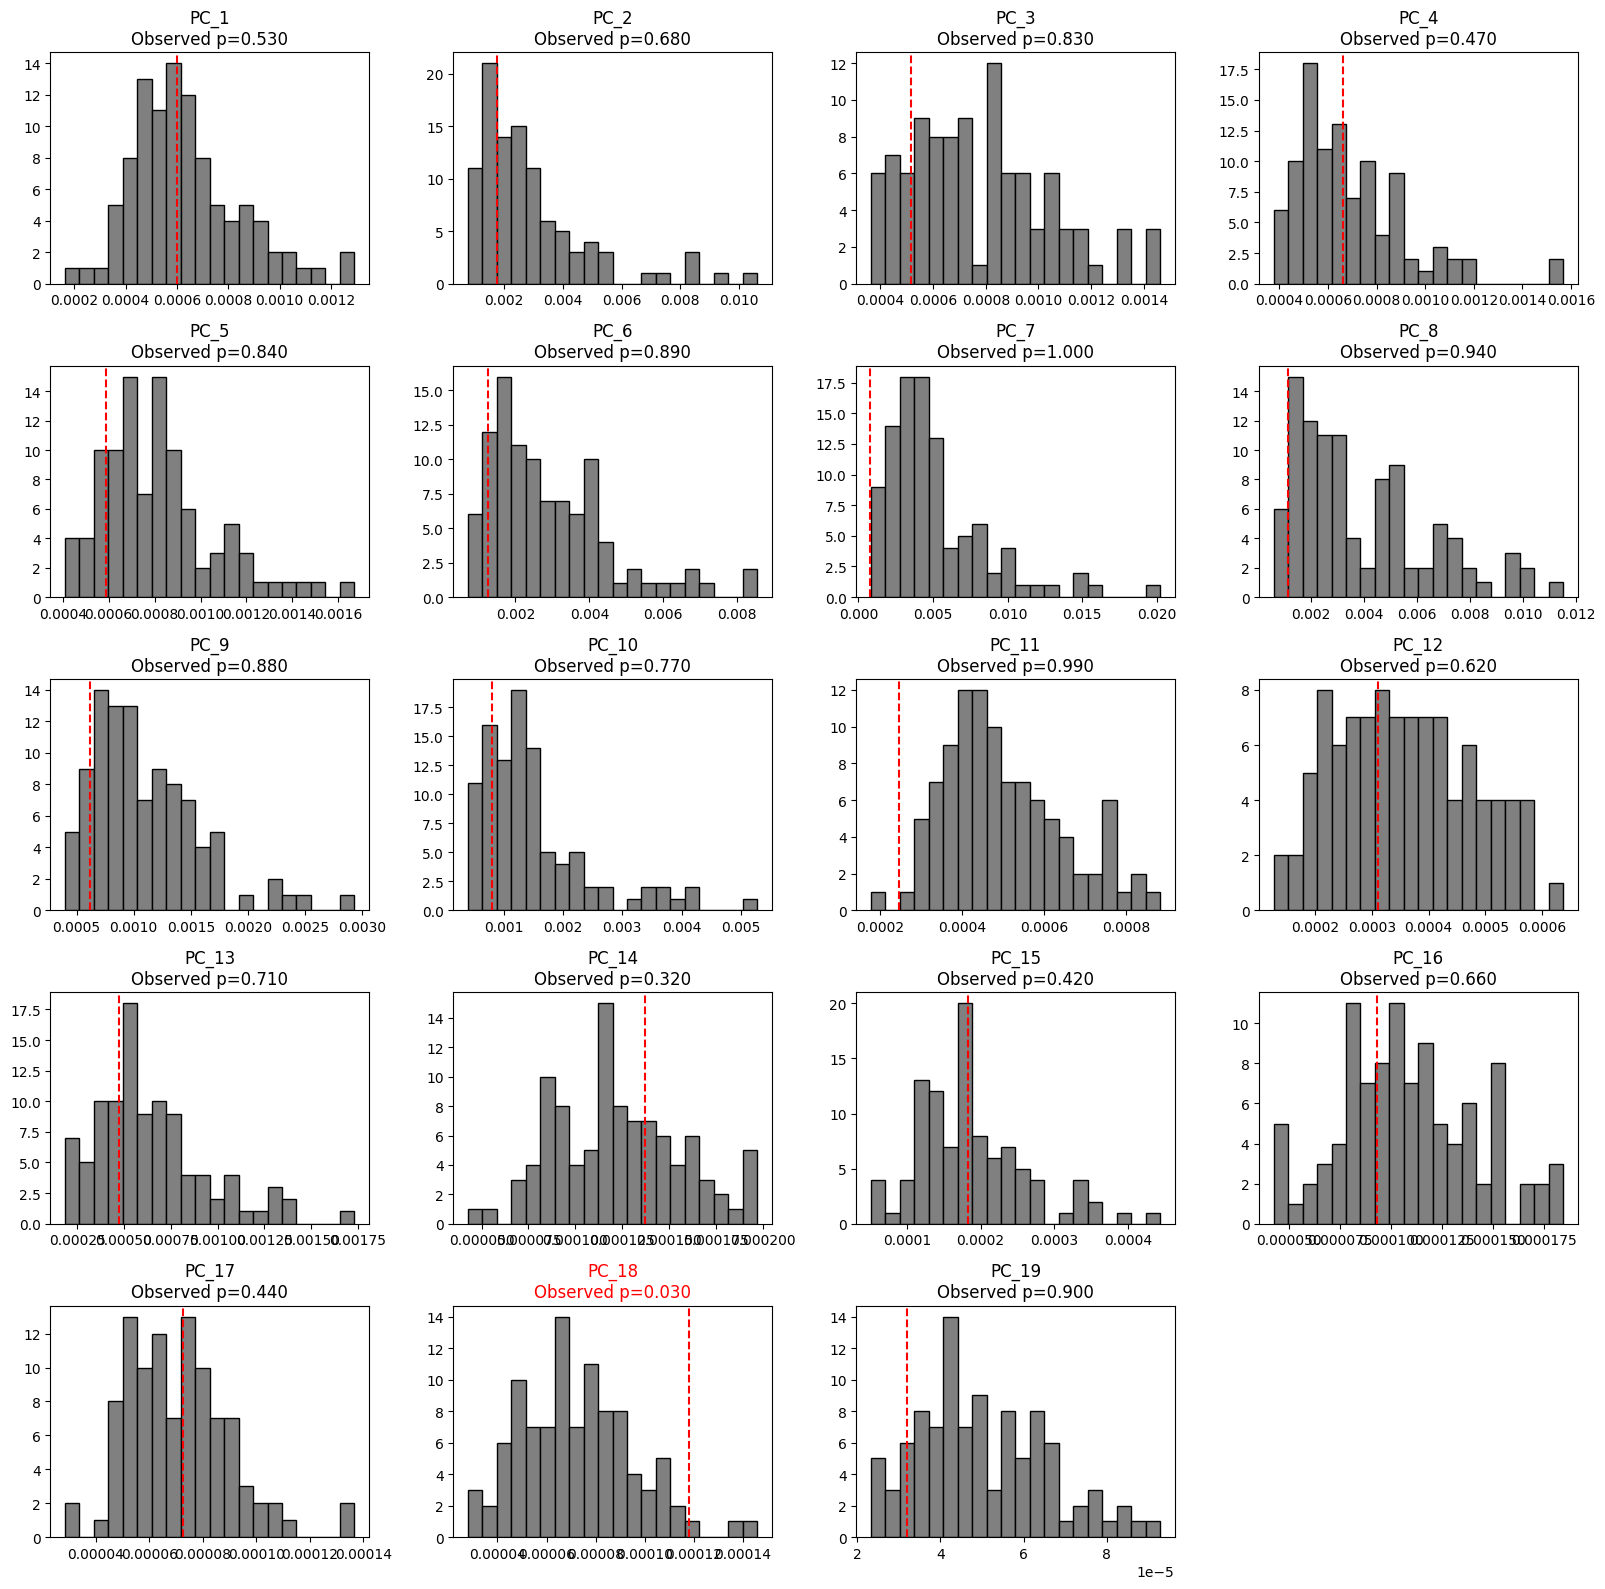

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

principal_components = [f"PC_{i}" for i in range(1, 20)]
bin_size = 0.1
tmin = df_mot_adaptation['peak_time'].min()
tmax = df_mot_adaptation['peak_time'].max()
edges = np.arange(tmin, tmax + bin_size, bin_size)

df = df_mot_adaptation.copy()
df['time_bin'] = pd.cut(df['peak_time'], bins=edges, include_lowest=True)

df_subj = df[['subject', 'group']].drop_duplicates()

n_permutations = 100
observed_var = {}
permuted_var = {pc: [] for pc in principal_components}

# Calculate observed variance for each PC
for pc in principal_components:
    df_imp = df[df['group'] == 'Implicit']
    df_exp = df[df['group'] == 'Explicit']
    mean_imp = df_imp.groupby(['subject', 'time_bin'])[pc].mean().unstack().mean(axis=0)
    mean_exp = df_exp.groupby(['subject', 'time_bin'])[pc].mean().unstack().mean(axis=0)
    diff_ = (mean_imp - mean_exp).sort_index()
    diff_ = diff_.reindex(diff_.index.categories, fill_value=np.nan)
    observed_var[pc] = diff_.var()

# Permutation test
for _ in range(n_permutations):
    shuffled_groups = np.random.permutation(df_subj['group'].values)
    df_subj['shuffled'] = shuffled_groups
    df_shuffled = df.merge(df_subj[['subject', 'shuffled']], on='subject')
    df_shuffled['group'] = df_shuffled['shuffled']
    
    for pc in principal_components:
        df_imp = df_shuffled[df_shuffled['group'] == 'Implicit']
        df_exp = df_shuffled[df_shuffled['group'] == 'Explicit']
        mean_imp = df_imp.groupby(['subject', 'time_bin'])[pc].mean().unstack().mean(axis=0)
        mean_exp = df_exp.groupby(['subject', 'time_bin'])[pc].mean().unstack().mean(axis=0)
        diff_ = (mean_imp - mean_exp).sort_index()
        diff_ = diff_.reindex(diff_.index.categories, fill_value=np.nan)
        permuted_var[pc].append(diff_.var())

# Plot histograms of permutation-based variances with observed value
fig, axs = plt.subplots(5, 4, figsize=(16, 16))
axs = axs.flatten()

for idx, pc in enumerate(principal_components):
    hist_vals = np.array(permuted_var[pc])
    p_value = np.mean(hist_vals >= observed_var[pc])  # one-sided test
    
    axs[idx].hist(hist_vals, bins=20, color='gray', edgecolor='black')
    axs[idx].axvline(observed_var[pc], color='red', linestyle='--')
    
    # Color the title if below a threshold, or just show p-value
    if p_value < 0.05:
        axs[idx].set_title(f"{pc}\nObserved p={p_value:.3f}", color='red')
    else:
        axs[idx].set_title(f"{pc}\nObserved p={p_value:.3f}")

# Remove empty subplots if needed
for idx in range(len(principal_components), len(axs)):
    fig.delaxes(axs[idx])

plt.tight_layout()
plt.show()


In [ ]:
# Debugging for PC_7
pc = 'PC_7'

n_permutations = 1000

# Observed variance calculation
df_imp = df[df['group'] == 'Implicit']
df_exp = df[df['group'] == 'Explicit']

# Mean calculation across subjects for each time bin
mean_imp = df_imp.groupby(['subject', 'time_bin'])[pc].mean().unstack().mean(axis=0)
mean_exp = df_exp.groupby(['subject', 'time_bin'])[pc].mean().unstack().mean(axis=0)

# Difference and observed variance
diff_ = (mean_imp - mean_exp).sort_index()
diff_ = diff_.reindex(diff_.index.categories, fill_value=np.nan)
observed_var = diff_.var()

# Permutation test
permuted_vars = []
for _ in range(n_permutations):
    # Shuffle group labels
    shuffled_groups = np.random.permutation(df_subj['group'].values)
    df_subj['shuffled'] = shuffled_groups
    df_shuffled = df.merge(df_subj[['subject', 'shuffled']], on='subject')
    df_shuffled['group'] = df_shuffled['shuffled']
    
    # Calculate variance for shuffled data
    df_imp_shuf = df_shuffled[df_shuffled['group'] == 'Implicit']
    df_exp_shuf = df_shuffled[df_shuffled['group'] == 'Explicit']
    
    mean_imp_shuf = df_imp_shuf.groupby(['subject', 'time_bin'])[pc].mean().unstack().mean(axis=0)
    mean_exp_shuf = df_exp_shuf.groupby(['subject', 'time_bin'])[pc].mean().unstack().mean(axis=0)
    
    diff_shuf = (mean_imp_shuf - mean_exp_shuf).sort_index()
    diff_shuf = diff_shuf.reindex(diff_shuf.index.categories, fill_value=np.nan)
    permuted_vars.append(diff_shuf.var())

# P-value calculation
p_value = np.mean(np.array(permuted_vars) >= observed_var)

# Visualization
plt.figure(figsize=(10, 6))
plt.hist(permuted_vars, bins=20, color='gray', edgecolor='black')
plt.axvline(observed_var, color='red', linestyle='--')
plt.title(f"{pc}\nObserved Variance: {observed_var:.4f}\np-value: {p_value:.4f}")
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.show()

print(f"Observed Variance: {observed_var}")
print(f"P-value: {p_value}")